<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Transfer leatning

In [1]:
!nvidia-smi

Mon Feb 19 08:11:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
 !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-19 08:11:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-19 08:11:22 (62.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-19 08:11:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 173.194.196.207, 173.194.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   150MB/s    in 1.1s    

2024-02-19 08:11:27 (150 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# create training and est directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
#  Check out the class names of the datset.
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# a batch of data.
for images, labels in train_data_10_percent.take(1):
  print(images, labels)


tf.Tensor(
[[[[ 12.198979   17.198978   47.454082 ]
   [ 19.306124   25.234695   51.47449  ]
   [ 22.92857    27.42347    48.933674 ]
   ...
   [ 56.14279    47.357056   47.714264 ]
   [ 44.545876   38.545876   38.545876 ]
   [ 38.45916    32.45916    32.45916  ]]

  [[ 11.117347   15.117347   42.16837  ]
   [ 10.132652   14.132652   39.14286  ]
   [ 14.397959   16.913263   35.811222 ]
   ...
   [ 55.382484   46.59675    46.953957 ]
   [ 37.724438   31.72444    31.72444  ]
   [ 32.81119    26.811192   26.811192 ]]

  [[ 25.418371   30.632656   60.704082 ]
   [ 26.785717   32.729595   60.21429  ]
   [ 29.362247   35.408165   60.09694  ]
   ...
   [ 60.407955   51.979427   49.979427 ]
   [ 40.800983   34.800983   34.8316   ]
   [ 35.50511    31.50511    32.50511  ]]

  ...

  [[235.25018   205.03592   120.3215   ]
   [228.28569   199.34181   119.571365 ]
   [238.57692   209.57692   131.14835  ]
   ...
   [163.40804   140.19377    71.673416 ]
   [164.47427   143.10187    75.775345 ]
   [1

## Mode 0: Building a transfer learning model using the keras Functional API

the Sequential QPI is straight-forward, it run the layers in sequential order.
The Funtional API give you more flexibility with the models.

In [11]:
# Create the base model with tf.keras.pplications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# freez he vase model (so the inderlying pre-trainined patterns aren't updated during training)
base_model.trainable = False

# Create inputs onto the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If sunign the ResNet you will have to normalize the inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

# pass the inputs to the base model
x = base_model(inputs)
print(f"Thape after passing the inputs through the base model: {x.shape}")

# Avarage pool the outputof the base model.
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape afer Global average pooling2D: {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs and the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model.
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="tranfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])


16705208/16705208 [==============================] - 0s 0us/step
Thape after passing the inputs through the base model: (None, 7, 7, 1280)
Shape afer Global average pooling2D: (None, 1280)
Saving TensorBoard log files to: tranfer_learning/10_percent_feature_extraction/20240219-081138
Epoch 1/5
24/24 [==============================] - 27s 297ms/step - loss: 1.8817 - accuracy: 0.4040 - val_loss: 1.3143 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 4s 163ms/step - loss: 1.0769 - accuracy: 0.7907 - val_loss: 0.8636 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 5s 175ms/step - loss: 0.7811 - accuracy: 0.8280 - val_loss: 0.6902 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.6245 - accuracy: 0.8800 - val_loss: 0.6189 - val_accuracy: 0.8470
Epoch 5/5
24/24 [==============================] - 4s 134ms/step - loss: 0.5480 - accuracy: 0.8733 - val_loss: 0.5489 - val_accuracy: 0.8553


In [12]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 77ms/step - loss: 0.5539 - accuracy: 0.8688


[0.5538610816001892, 0.8687999844551086]

In [13]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

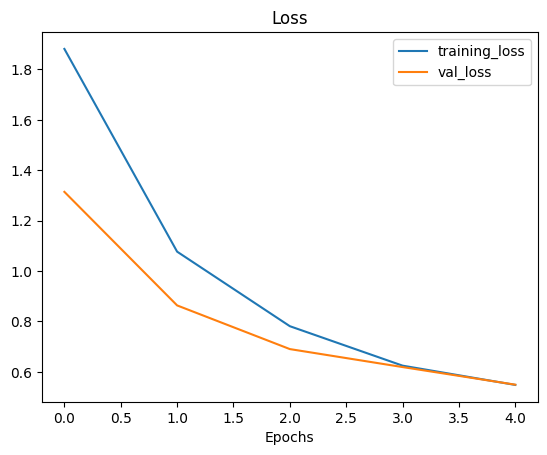

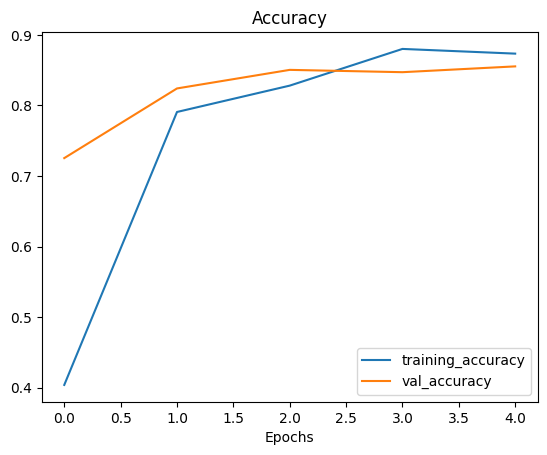

In [16]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model.
Demonstrate the Global Avarage Pooling @D layer...
the tensor after the model goes through "base_model" of shape (None, 7, 7, 1280)...
But then when it passes through GlobalAvaragePooling2D, it turns into (none, 1280)

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}")

# pass it through a global average pooling 2D layer.
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor {global_average_pooling_tensor}")

# Check the shape of the different tnsors.
print(f"Shape of the input tensor {input_tensor.shape} \n Shape of the globla pooled tensor {global_average_pooling_tensor.shape}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of the input tensor (1, 4, 4, 3) 
 Shape of the globla pooled tensor (1, 3)


In [18]:
# GolabalAveragePooling layer replocation.
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🔑NOTE: One of the reasons feature extraction transer learning is named how it is is
because what often happens is pretraained model outpus a feature vector.
- A Feature vector is a learned reapresentation of a input data base on how th model sees it.

## Running a series of experimentations
1. `Model_1` - use feature extraction transfer learning with 1% of the training data with data orgumentation.
2. `Model_2`  Use feature extraction transfer learning with 10% of the training with data orgmentation.
3. `Model_3` - use fine-tinning transfer learning on 10% of the training data with data augmentaion.
4. `Model_4` - Use fine-tuning transfer learning on 100% of the training data with data augmentation

**NOTE:** Thtoughout all the experimentation the same test dataset will be ised to evaluate the models. This is to ensure the consistence across evaluation metrics.

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2024-02-19 08:12:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.207, 108.177.120.207, 173.194.206.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   151MB/s    in 0.8s    

2024-02-19 08:12:47 (151 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Creae test and training dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# the number of images that we are working with.
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [22]:
# set up data loaders.
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size= BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal fliping, rotation, zoom etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255)
], name="Data_augmentation")

(-0.5, 545.5, 247.5, -0.5)

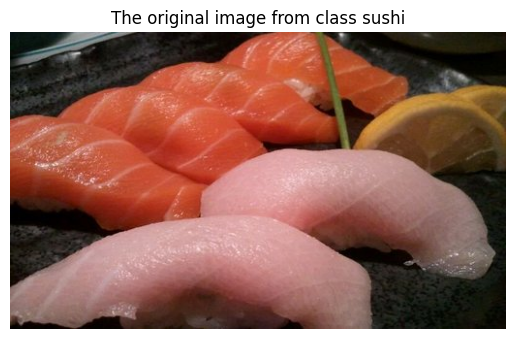

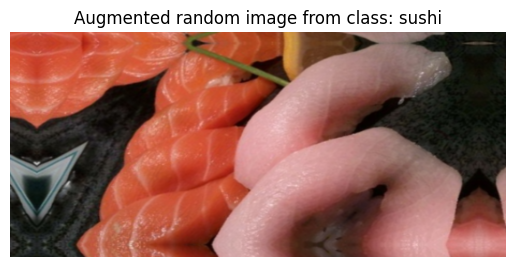

In [24]:
# View the random image and compare it to ists Augmented version.
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# REad in random image
img = mping.imread(random_image_path)
plt.imshow(img)
plt.title(f"The original image from class {target_class}")
plt.axis(False  )

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img))
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [25]:
target_dir

'10_food_classes_1_percent/train/sushi'

### Model 1: Feature extraction transfer learning on 1% of the data with data augmentation.


In [26]:
# Setup imput shape and base model, Freezing the base model layer
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="Input_layer")

# Add in data augmentation Sequential as a layer
x = data_augmentation(inputs)

# Giv base model the inputs (after augmentation) and dont ttrain it
x = base_model(x, training=False)

# Pool output featres of the base model.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dence layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs.
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240219-081254
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.3874 - accuracy: 0.0429 - val_loss: 2.3062 - val_accuracy: 0.0954
Epoch 2/5
3/3 [==============================] - 10s 4s/step - loss: 2.3185 - accuracy: 0.1000 - val_loss: 2.3315 - val_accuracy: 0.1020
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 2.3337 - accuracy: 0.1000 - val_loss: 2.3294 - val_accuracy: 0.1020
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 2.3298 - accuracy: 0.1143 - val_loss: 2.3170 - val_accuracy: 0.1135
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 2.3267 - accuracy: 0.1000 - val_loss: 2.3089 - val_accuracy: 0.1102


In [27]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [28]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 64ms/step - loss: 2.3199 - accuracy: 0.1000


[2.319852828979492, 0.10000000149011612]

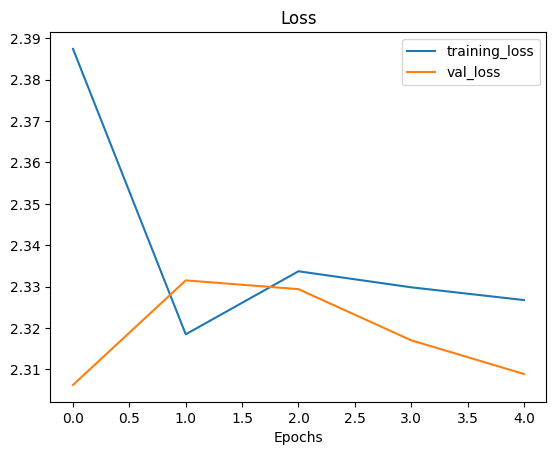

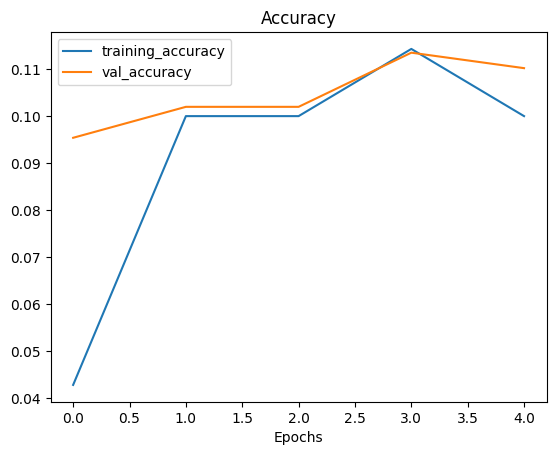

In [29]:
plot_loss_curves(history_1_percent)

### Model 2: 10 percent of data with data augmentation.

In [30]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-02-19 08:13:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   115MB/s    in 1.4s    

2024-02-19 08:13:49 (115 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [31]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [32]:
# set up data imputs.
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
#Create model 2 data augmentation.
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Data augmentation layer.
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    # Preprocessing.Rescaling(1./225) this is comment sincce effitientNet have inbuild recalling.

], name="data_augmantation")

input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

# Create the inputs and outputs (including the layers between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # This ony happens on the training data.
x = base_model(x, training=False)  #pass augmentaed emange to base model but keeps its inference mode,
x = layers.GlobalAveragePooling2D(name='Global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation="softmax", name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

# compile the model.
model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [34]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmantation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creatintg a model training Checkpoints

The modelCheckpoint callback intermediately saves the model diring training. This is usefull fo that we can comeback and continue from where we left from.

In [65]:
# Checkpoint path
checkpoint_path = "ten_percent_model_checkpionts_waights/checkpoint.ckpt"

# Create a modelCheckpoint callback that saves the models weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=False,
                                                          save_freq='epoch',
                                                          verbose=1)

### Fit model 2 With the model callback.


In [66]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240219-082128
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.8200
Epoch 1: saving model to ten_percent_model_checkpionts_waights/checkpoint.ckpt
24/24 [==============================] - 13s 527ms/step - loss: 0.5812 - accuracy: 0.8200 - val_loss: 0.5172 - val_accuracy: 0.8470
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.9013
Epoch 2: saving model to ten_percent_model_checkpionts_waights/checkpoint.ckpt
24/24 [==============================] - 13s 518ms/step - loss: 0.3132 - accuracy: 0.9013 - val_loss: 0.4314 - val_accuracy: 0.8635
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9333
Epoch 3: saving model to ten_percent_model_checkpionts_waights/checkpoint.ckpt
24/24 [==============================] - 12s 505ms/step - loss: 0.2110 - accuracy: 0.9333 - val_loss: 0.5226 - val_accuracy: 0.8438
E

In [67]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.5539 - accuracy: 0.8688


[0.5538609623908997, 0.8687999844551086]

In [68]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 64ms/step - loss: 0.5238 - accuracy: 0.8480


[0.5237765908241272, 0.8479999899864197]

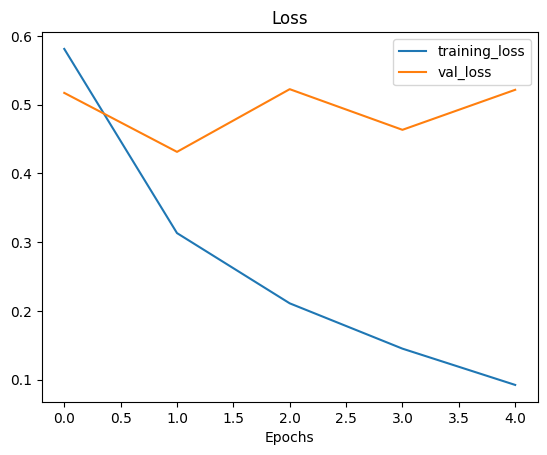

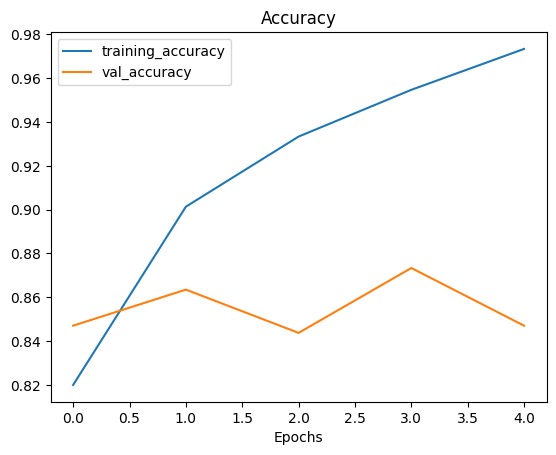

In [69]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights
Loading Checkpoints weights returnin  a model to a specific checkpoint

In [70]:
model_2.load_weights(checkpoint_path)

In [71]:
# Evaluate model_2 with loaded wights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.5238 - accuracy: 0.8480


In [72]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [73]:
# Check the clossness of the models.
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [74]:
# Che the diffrence between the two results.
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3 Fine-tuning an existing model on 10 percent of data.
- THis to make some of the frozeen layers of the model tro be trainable.
- how many layers to unfeez when training.
- Fine tuning involves unfreezing the layers closer to the top.

**🔑Note** Fine-tuning works best after training a feature extraction model for a fer epoches with loger amounts of data

In [75]:
# Check the layers in model 2
model_2.layers

In [76]:
# Check if all the layers in the model are trainable.
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7864ce1c3bb0> True
<keras.src.engine.sequential.Sequential object at 0x7864c7d55840> True
<keras.src.engine.functional.Functional object at 0x7864c7bf17e0> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7864c7d57f70> True
<keras.src.layers.core.dense.Dense object at 0x78654f8b4d60> True


In [77]:
# Evaluate the layers that are in the base model.
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [78]:
# Find the number of parameters in model 2 tran are trainable.
print(len(model_2.layers[2].trainable_variables))

10


In [79]:
 # make the last ten layers of the base model to be trainable.
base_model.trainable = True

# Freez all the layers aprt from the last 01
for layer in base_model.layers[:-10]:
  layer.trainable = False


# Recombile the model. (This is nessessary for any time the changes are made to the model.)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),   # lowetr the learning rate by 10* (ULMFIT)
                metrics=['accuracy'])


In [80]:
# Layers that are tunable.
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [81]:
print(len(model_2.trainable_variables))

12


In [82]:
# Fine tune for other five epoches.
fine_tune_epochs = initial_epochs + 5

# Refit the base model.
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                           epochs=fine_tune_epochs,
                           validation_data=test_data,
                           validation_steps=int(0.25 * len(test_data)),
                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                           callbacks=[create_tensorboard_callback(dir_name="trensfer_learning",
                                                                  experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: trensfer_learning/10_percent_fine_tune_last_10/20240219-082301
Epoch 5/10
24/24 [==============================] - 23s 606ms/step - loss: 0.1252 - accuracy: 0.9600 - val_loss: 0.4829 - val_accuracy: 0.8503
Epoch 6/10
24/24 [==============================] - 12s 480ms/step - loss: 0.0691 - accuracy: 0.9827 - val_loss: 0.5583 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 12s 476ms/step - loss: 0.0770 - accuracy: 0.9747 - val_loss: 0.5291 - val_accuracy: 0.8684
Epoch 8/10
24/24 [==============================] - 13s 516ms/step - loss: 0.0609 - accuracy: 0.9813 - val_loss: 0.4855 - val_accuracy: 0.8701
Epoch 9/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0414 - accuracy: 0.9893 - val_loss: 0.4333 - val_accuracy: 0.8816
Epoch 10/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.5249 - val_accuracy: 0.8701


In [83]:
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 64ms/step - loss: 0.5029 - accuracy: 0.8724


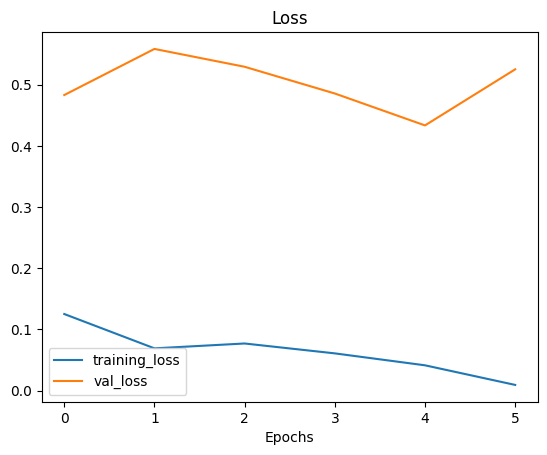

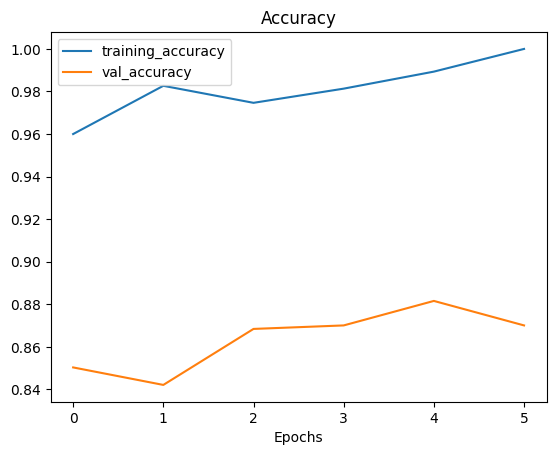

In [84]:
# Check the loss curve for the fine-tuned model.
plot_loss_curves(history_fine_10_percent_data_aug)

#### Function to compare traing history.

In [85]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two tensorflow history objects
  """
  # Get arogina history measures
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Compine original history with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="val_Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="start Fine Tuning")
  plt.legend(loc='lower right')
  plt.title("Training and validation accuracy")

  # Make Plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Trainig Loss")
  plt.plot(total_val_loss, label="val_loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="start fine tuning")
  plt.legend(loc='upper right')
  plt.title("Training and Validation Loss")

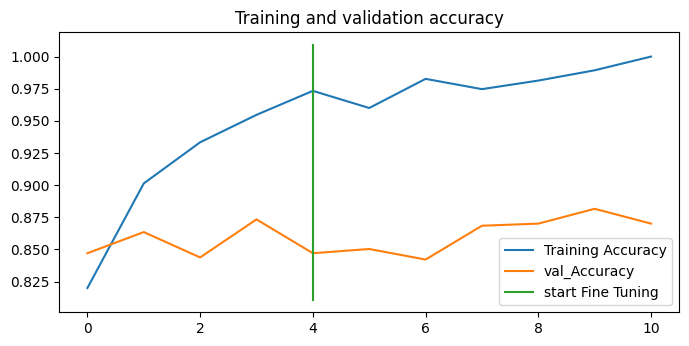

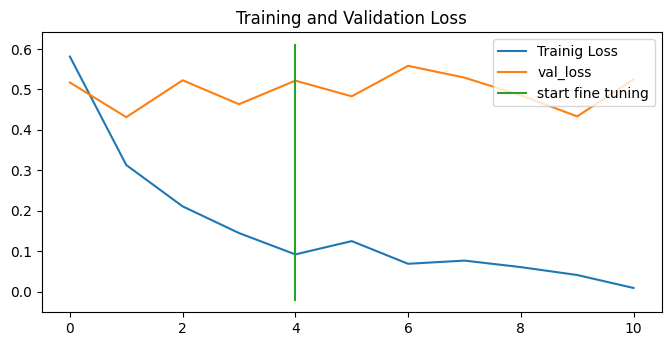

In [86]:
compare_historys(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

## Model 4: Fine turn the model on all the training data.

In [87]:
# Download and unzip 10 classes of food101 data with all images.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-02-19 08:24:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  53.0MB/s    in 6.4s    

2024-02-19 08:24:34 (77.5 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [88]:
# set up the training ad test dir
treain_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"


In [89]:
# The nimber of images that are in the data set
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [90]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(treain_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [91]:
test_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [92]:
# Evaluate model 2 on all the data
model_2.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 0.5029 - accuracy: 0.8724


[0.5028550624847412, 0.8723999857902527]

In [93]:
results_fine_tuned_10_percent

[0.5028550624847412, 0.8723999857902527]

T train a fine-tuning model (model 4) you need to revert model_2 back to its feature extraction wieghts

In [94]:
# Load wights from checkpoint,
model_2.load_weights(checkpoint_path)

In [95]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 77ms/step - loss: 0.5238 - accuracy: 0.8480


[0.5237768292427063, 0.8479999899864197]

In [96]:
results_10_percent_data_aug

[0.5237765908241272, 0.8479999899864197]

In [99]:
# Check the trainable number of layers.
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmantation True
2 efficientnetb0 True
3 Global_average_pooling_2D True
4 output_layer True


In [101]:
for index, layer in enumerate(model_2.layers[2].layers):
  print(index, layer.name, layer.trainable)

0 input_3 False
1 rescaling_5 False
2 normalization_2 False
3 rescaling_6 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [102]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

In [103]:
# Train and finetune the model to 100% of the training data.
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240219-085304
Epoch 5/10
235/235 [==============================] - 94s 357ms/step - loss: 0.5441 - accuracy: 0.8300 - val_loss: 0.2756 - val_accuracy: 0.9062
Epoch 6/10
235/235 [==============================] - 76s 322ms/step - loss: 0.3440 - accuracy: 0.8863 - val_loss: 0.2744 - val_accuracy: 0.9161
Epoch 7/10
235/235 [==============================] - 71s 299ms/step - loss: 0.2725 - accuracy: 0.9105 - val_loss: 0.2663 - val_accuracy: 0.9227
Epoch 8/10
235/235 [==============================] - 63s 268ms/step - loss: 0.2207 - accuracy: 0.9301 - val_loss: 0.2504 - val_accuracy: 0.9227
Epoch 9/10
235/235 [==============================] - 57s 242ms/step - loss: 0.1818 - accuracy: 0.9393 - val_loss: 0.2786 - val_accuracy: 0.9112
Epoch 10/10
235/235 [==============================] - 56s 239ms/step - loss: 0.1533 - accuracy: 0.9475 - val_loss: 0.2994 - val_accuracy: 0.9128


In [104]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 81ms/step - loss: 0.3127 - accuracy: 0.9080


[0.31272920966148376, 0.9079999923706055]

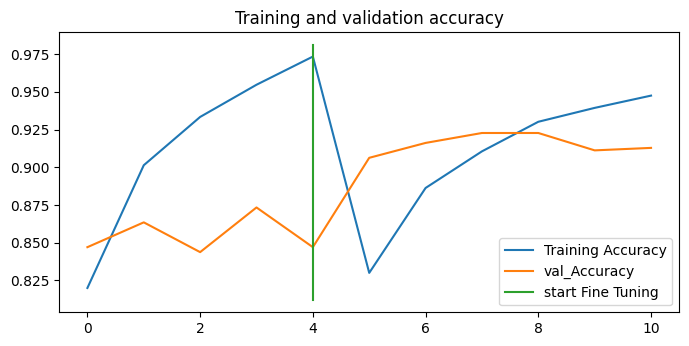

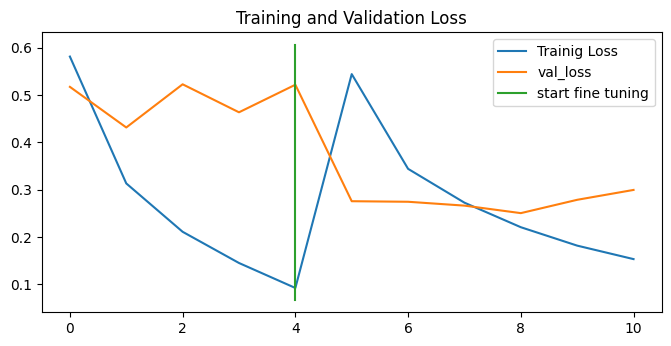

In [105]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)